<a href="https://colab.research.google.com/github/antoalli/AlliDataScience/blob/master/bioinformatics_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Aug  6 13:47:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import tensorflow as tf
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/antonio')

Drive already mounted at /antonio; to attempt to forcibly remount, call drive.mount("/antonio", force_remount=True).


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import matplotlib.pyplot as plt
def imshow(img):
    npimg = img / 2 + 0.5     # unnormalize    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [6]:
!ls '/antonio/My Drive/CRC_reduced_bioinf'

10_V  1_AC   29_H     37_Serr  67_T  filelist.txt	trainval80_gdrive.txt
11_V  21_AC  2_AC     38_Serr  73_H  README.pdf		trainval80.txt
15_V  26_H   34_Serr  5_T      74_V  test20_gdrive.txt
19_T  28_H   36_Serr  65_AC    9_T   test20.txt


In [0]:
#!rm -r '/antonio/My Drive/CRC_checkpoints/train1'

In [0]:
import os
import os.path as osp

# PREPARING CHECKPOINTS DIR
checkpoints_dir = '/antonio/My Drive/CRC_checkpoints/train1'
if not osp.exists(checkpoints_dir):
  os.makedirs(checkpoints_dir)

In [0]:
import os.path as osp
# Reading the dataset
# 2 modes: 'file' or 'folder'
def read_images(dataset_path, split):
    imagepaths, labels, patients = list(), list(), list()
    # Read dataset file
    with open(osp.join(dataset_path, split) + '.txt', "r") as f:
      # e.g. 2 34 /Users/antonioalliegro/Downloads/CRC_reduced_bioinf/34_Serr/34_Serr_168.png
      data = f.read().splitlines()
      for d in data:
        imagepaths.append(osp.join(dataset_path, d.split(';')[2]))
        patients.append(int(d.split(';')[1]))
        labels.append(int(d.split(';')[0]))
      return imagepaths, labels, patients

In [0]:
DATASET_PATH = '/antonio/My Drive/CRC_reduced_bioinf' # the dataset file or root folder path.
# Image Parameters
N_CLASSES = 5 # CHANGE HERE, total number of classes

tr_imagepaths, tr_labels, tr_patients = read_images(DATASET_PATH, 'trainval80_gdrive')
test_imagepaths, test_labels, test_patients = read_images(DATASET_PATH, 'test20_gdrive')

In [11]:
print(tr_imagepaths[:100])
print(tr_labels[:100])
print(tr_patients[:100])

['/antonio/My Drive/CRC_reduced_bioinf/34_Serr/34_Serr_717.png', '/antonio/My Drive/CRC_reduced_bioinf/36_Serr/36_Serr_812.png', '/antonio/My Drive/CRC_reduced_bioinf/11_V/11_V_169Aug28.png', '/antonio/My Drive/CRC_reduced_bioinf/34_Serr/34_Serr_531.png', '/antonio/My Drive/CRC_reduced_bioinf/2_AC/2_AC_120.png', '/antonio/My Drive/CRC_reduced_bioinf/67_T/67_T_1443.png', '/antonio/My Drive/CRC_reduced_bioinf/36_Serr/36_Serr_2759.png', '/antonio/My Drive/CRC_reduced_bioinf/37_Serr/37_Serr_4.png', '/antonio/My Drive/CRC_reduced_bioinf/5_T/5_T_44.png', '/antonio/My Drive/CRC_reduced_bioinf/73_H/73_H_565.png', '/antonio/My Drive/CRC_reduced_bioinf/36_Serr/36_Serr_1254.png', '/antonio/My Drive/CRC_reduced_bioinf/36_Serr/36_Serr_3627.png', '/antonio/My Drive/CRC_reduced_bioinf/34_Serr/34_Serr_652.png', '/antonio/My Drive/CRC_reduced_bioinf/5_T/5_T_204Aug71.png', '/antonio/My Drive/CRC_reduced_bioinf/36_Serr/36_Serr_1668.png', '/antonio/My Drive/CRC_reduced_bioinf/29_H/29_H_288.png', '/antonio

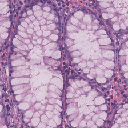

In [12]:
import IPython.display as display
display.display(display.Image(test_imagepaths[33]))

In [0]:
def parse_function(filename, label):
    image_string = tf.read_file(filename)
    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=3)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.resize_images(image, [128, 128])  # no resize for now
    return image, label

def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    # Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label


In [0]:
# CREATING TRAIN DATASET
batch_size = 128  # BATCH SIZE HERE!!!
train_dataset = tf.data.Dataset.from_tensor_slices((tr_imagepaths, tr_labels))
train_dataset = train_dataset.shuffle(len(tr_labels))
train_dataset = train_dataset.map(parse_function, num_parallel_calls=4)
# train_dataset = train_dataset.map(train_preprocess, num_parallel_calls=4)  # PREPROCESSING - DATAAUG IS HERE
train_dataset = train_dataset.batch(batch_size)
#train_dataset = train_dataset.prefetch(1)  # ? NOT SURE ABOUT WHAT IS DOING

# CREATING TEST DATASET, no data augmentation on test data
test_dataset = tf.data.Dataset.from_tensor_slices((test_imagepaths, test_labels))
test_dataset = test_dataset.shuffle(len(test_labels))
test_dataset = test_dataset.map(parse_function, num_parallel_calls=4)
test_dataset = test_dataset.batch(batch_size)
#test_dataset = test_dataset.prefetch(1)  # ? NOT SURE ABOUT WHAT IS DOING



In [17]:
print(len(tr_labels))

11075


W0806 13:50:06.973284 139694926251904 deprecation.py:323] From <ipython-input-18-17d8ac8d8756>:2: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Image shape:  (128, 128, 3)


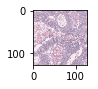

labels:  [0 3 2 0 0 2 2 1 2 0 2 2 2 2 1 2 0 4 0 2 1 1 4 2 4 4 3 1 2 1 3 2 2 2 2 0 3
 1 2 1 2 0 1 2 1 2 2 2 2 2 0 0 3 0 3 3 3 2 2 2 1 2 2 4 1 2 1 2 3 2 0 0 1 2
 2 2 0 3 1 3 3 2 2 2 3 2 3 2 2 3 2 3 3 1 2 3 4 2 2 0 2 0 4 3 4 2 2 2 2 2 3
 3 3 1 4 1 4 4 2 2 2 0 3 2 0 1 1 2]
shape batch images:  (128, 128, 128, 3)
----------------------------------------------------------------------
Image shape:  (128, 128, 3)


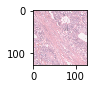

labels:  [0 0 0 0 0 1 4 2 1 3 2 2 2 4 0 4 0 3 2 4 4 4 0 3 2 2 4 2 2 2 1 3 0 3 0 1 0
 0 0 3 3 4 3 2 2 2 1 3 4 2 2 1 3 1 2 3 2 2 1 2 0 2 4 4 1 2 0 1 3 4 1 2 1 4
 2 3 4 2 0 3 0 4 2 0 0 2 2 3 3 2 3 3 0 1 3 3 2 0 0 3 2 3 3 3 3 4 1 2 3 2 4
 2 0 1 0 3 0 2 0 4 0 2 2 4 2 3 2 2]
shape batch images:  (128, 128, 128, 3)
----------------------------------------------------------------------
Image shape:  (128, 128, 3)


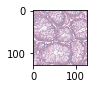

labels:  [2 2 0 1 1 3 2 1 2 3 2 3 4 2 2 1 0 2 0 4 2 2 3 3 1 4 2 2 4 4 2 2 3 2 2 0 2
 4 4 3 2 0 2 3 0 0 1 3 2 2 2 2 2 0 4 2 2 2 3 2 2 2 3 1 2 2 4 4 2 2 0 2 1 0
 3 1 0 2 3 4 0 2 2 2 0 1 2 3 2 3 2 0 4 0 2 1 3 0 1 3 2 3 1 0 0 2 0 2 4 1 0
 2 1 4 2 0 0 2 1 0 2 4 2 2 2 0 4 2]
shape batch images:  (128, 128, 128, 3)
----------------------------------------------------------------------
Image shape:  (128, 128, 3)


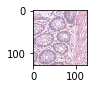

labels:  [2 2 4 2 2 2 1 3 4 1 3 4 4 0 2 0 3 3 3 2 2 3 4 2 4 0 4 2 3 3 2 3 2 2 0 0 2
 3 2 0 1 0 4 2 3 4 3 1 2 2 2 0 2 2 2 4 1 3 2 3 1 2 0 0 4 2 4 0 0 4 2 2 3 1
 2 2 2 3 2 2 2 3 0 1 2 2 0 3 0 2 2 2 1 3 2 0 2 0 4 2 1 3 3 2 3 4 2 3 3 2 2
 0 2 2 1 3 0 2 2 0 2 2 2 4 2 2 2 0]
shape batch images:  (128, 128, 128, 3)
----------------------------------------------------------------------


In [18]:
# EXAMPLE!!!
# EXTRACTING BATCH IMAGES FROM DATASET: I do not want to change training process! Continue using feed dict!

iterator = train_dataset.make_initializable_iterator()
batch_data = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    for i in range(4):
      data = sess.run(batch_data)
      print("Image shape: ", np.shape(data[0][0]))
      imshow(data[0][0])
      print("labels: ", data[1])
      print("shape batch images: ", np.shape(data[0]))
      print ('-' * 70)

(128, 128, 3)


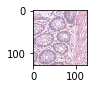

(128, 128, 3)


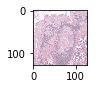

(128, 128, 3)


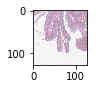

(128, 128, 3)


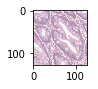

(128, 128, 3)


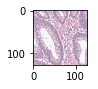

(128, 128, 3)


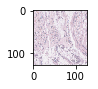

(128, 128, 3)


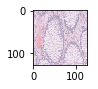

(128, 128, 3)


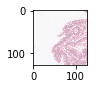

(128, 128, 3)


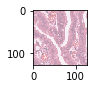

(128, 128, 3)


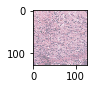

In [19]:
for i in range(10):
  print(np.shape(data[0][i]))
  imshow(data[0][i])

In [23]:
print(batch_size)

128


In [0]:
# EXAMPLE 2!!! EPOCH SIMULATION
iterator = train_dataset.make_initializable_iterator()
batch_data = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sum_ = 0
    while True:
      try:
        data = sess.run(batch_data)
        sum_ += len(data[1])
      except tf.errors.OutOfRangeError:
        print("Sum is %d !!" % sum_)
        break

In [21]:
print("Num classes: %d" % N_CLASSES)

Num classes: 5


In [22]:
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling2D, Flatten, Dropout

"""
# BNN MODEL!
inputs = Input(shape=(128, 128, 3))  # DEPENDS ON IMAGE SHAPE!!
x = tfp.layers.Convolution2DReparameterization(32, kernel_size=5,  padding="SAME", activation=tf.nn.relu)(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2],  strides=[2, 2],  padding="SAME")(x)
x = tfp.layers.Convolution2DReparameterization(64, kernel_size=5,  padding="SAME",  activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x = tf.keras.layers.Flatten()(x)
x = tfp.layers.DenseFlipout(1024, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.50)(x)  # FIXING DROPOUT PROBABILITY? TRY REDUCING IT!
outputs = tfp.layers.DenseFlipout(N_CLASSES)(x)
model = Model(inputs, outputs)
model.summary()
"""

inputs = Input(shape=(128, 128, 3))  # DEPENDS ON IMAGE SHAPE!!
x = tfp.layers.Convolution2DReparameterization(32, kernel_size=5,  padding="SAME", activation=tf.nn.relu)(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2],  strides=[2, 2],  padding="SAME")(x)
x = tfp.layers.Convolution2DReparameterization(64, kernel_size=5,  padding="SAME",  activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x = tf.keras.layers.Flatten()(x)
x = tfp.layers.DenseFlipout(1024, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.50)(x)  # FIXING DROPOUT PROBABILITY? TRY REDUCING IT!
outputs = tfp.layers.DenseFlipout(N_CLASSES)(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_reparameterization (C (None, 128, 128, 32)      4832      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_reparameterization_1  (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1024)              134218

In [0]:
neural_net = tf.keras.Sequential([
    tfp.layers.Convolution2DFlipout(6, kernel_size=5, padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME"),
    tfp.layers.Convolution2DFlipout(16, kernel_size=5, padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME"),
    tfp.layers.Convolution2DFlipout(120, kernel_size=5, padding="SAME" ,activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(84, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(N_CLASSES)])

In [0]:
TRAIN_LEN = len(tr_imagepaths)

###########################
#  PLACEHOLDERS AND OPS.  #
###########################

x = tf.placeholder(shape=[None, 128, 128, 3], dtype=tf.float32)
y = tf.placeholder(shape=[None], dtype=tf.int32)
n = tf.placeholder(shape=[], dtype=tf.float32)

logits = model(x)
probs = tf.nn.softmax(logits, axis=1)
labels_distribution = tfp.distributions.Categorical(logits=logits)
log_probs = labels_distribution.log_prob(y)

neg_log_likelihood = -tf.reduce_mean(log_probs)
kl = sum(model.losses) / TRAIN_LEN
elbo_loss = neg_log_likelihood + kl

correct_preds = tf.equal(tf.cast(y, dtype=tf.int64), tf.argmax(probs, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

# OPTIMIZER PARAMS: from Adam paper, this is a sort of good default settings
init_lr = 0.001
b1 = 0.9
b2 = 0.999  # should be close to 1
e = 1e-08

optimizer = tf.train.AdamOptimizer(learning_rate=init_lr, beta1=b1, beta2=b2, epsilon=e)
train_op = optimizer.minimize(elbo_loss)
init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                   tf.compat.v1.local_variables_initializer())

In [24]:
print("What was batch size? %d!" % batch_size)

What was batch size? 128!


In [25]:
print("placeholder x: ", x)
print("placeholder y: ", y)
print("placeholder n: ", n)

placeholder x:  Tensor("Placeholder:0", shape=(?, 128, 128, 3), dtype=float32)
placeholder y:  Tensor("Placeholder_1:0", shape=(?,), dtype=int32)
placeholder n:  Tensor("Placeholder_2:0", shape=(), dtype=float32)


In [26]:
import math
print("NUM BATCH PER EPOCH")
print("not approx: ", TRAIN_LEN/float(batch_size))
print("approx: ", math.ceil(TRAIN_LEN/float(batch_size)))

N_EPOCHS = 100
N_BATCH = (math.ceil(TRAIN_LEN/float(batch_size)))

NUM BATCH PER EPOCH
not approx:  86.5234375
approx:  87


In [27]:
print("TRAIN_LEN: ", TRAIN_LEN)
print("batch_size: ", batch_size)

TRAIN_LEN:  11075
batch_size:  128


In [36]:
!nvidia-smi

Tue Aug  6 12:29:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |     71MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [28]:
print("checkpoints in: ", checkpoints_dir)

checkpoints in:  /antonio/My Drive/CRC_checkpoints/train1


In [0]:
!ls '/antonio/My Drive/CRC_checkpoints/train1'


In [0]:
def test_model(model_id, session, test_iterator, next_data):
  session.run(test_iterator.initializer)  # initializing iterator
  sum_accuracy, n_batch = 0, 0

  while True:
    try:
      data = session.run(next_data)   
    except tf.errors.OutOfRangeError:
      print('%s: accuracy on Test Set is %.4f' % (model_id, sum_accuracy/float(n_batch)))
      break;
      
    n_batch += 1
    test_images, test_labels = data[0], data[1]
    feed_dict = {x: test_images, y: test_labels, n: batch_size}
    loss_tmp, accuracy_tmp = session.run([elbo_loss, accuracy], 
                                        feed_dict=feed_dict)
    sum_accuracy += accuracy_tmp
  

In [36]:
history_loss_train = []  # it
history_acc_train = []  # it
show_step = 100  # logging each 10 batch


######################
# MANAGING ITERATORS #
######################

# TRAIN ITERATOR
iterator = train_dataset.make_initializable_iterator()
batch_data = iterator.get_next()

# TEST ITERATOR
test_iterator = test_dataset.make_initializable_iterator()
test_data = test_iterator.get_next()

with tf.compat.v1.Session() as sess:
  saver = tf.train.Saver()
  sess.run(init_op)
  check = [0 for i in range(N_EPOCHS)]
  
  for i in range(N_EPOCHS):  # i is EPOCH idx
    # re-initialize iterator here! EACH EPOCH!!
    sess.run(iterator.initializer)
    
    ep_train_loss, ep_train_accuracy = 0, 0
    num_batch = 0  # num of batches for current epoch
    
    print ('-' * 80)
    print("Epoch %d/%d" % (i, N_EPOCHS))
    
    while True:  # BATCH
      try:
        data = sess.run(batch_data)
        
      except tf.errors.OutOfRangeError:
        # EPOCH LOG
        print("Epoch %d/%d - Loss: %.3f, Accuracy: %.3f" % (i, N_EPOCHS, ep_train_loss/float(num_batch), ep_train_accuracy/float(num_batch)))
        
        # EPOCH SAVE MODEL
        # saver.save(sess, 'epoch_%d_model' % i)
        save_path = osp.join(checkpoints_dir, 'epoch_%d_model.ckpt' % i)
        
        if (i + 1) % 10 == 0:
          # save model each 10 epochs
          saver.save(sess, save_path)
          print("New checkpoint saved at: %s" % save_path)
        
        test_model('epoch_%d_model.ckpt' % i, sess, test_iterator, test_data)  # TEST MODEL ON TEST SET!
        break  # END EPOCH
      
      images, labels = data[0], data[1] 
      num_batch += 1
      check[i] += len(labels)
      feed_dict = {x: images, y: labels, n: batch_size}
      sess.run(train_op, feed_dict=feed_dict)
      loss_tmp, accuracy_tmp, probs_tmp = sess.run([elbo_loss, accuracy, probs], 
                                        feed_dict=feed_dict)
      print("*" * 70)
      print("Accuracy temp: ", accuracy_tmp)
      print("Ground Truth labels: ", labels)
      print("pred: ", np.argmax(probs_tmp, axis=1))
      print("*" * 70)
      ep_train_loss += loss_tmp
      ep_train_accuracy += accuracy_tmp
      history_loss_train.append(loss_tmp)
      history_acc_train.append(accuracy_tmp)
      
      if (num_batch+1) % show_step == 0:
        print ('Batch: ' + str(num_batch + 1) + '  Train Loss: ' + str(loss_tmp) + '  Train Accuracy: ' + str(accuracy_tmp))

  print("End training, check distribution is: ", check)
  



--------------------------------------------------------------------------------
Epoch 0/100
**********************************************************************
Accuracy temp:  0.3828125
Ground Truth labels:  [3 3 1 2 3 2 3 4 1 4 2 2 2 1 0 3 2 2 3 2 3 3 0 2 2 2 1 1 2 4 2 2 3 2 2 0 4
 3 3 1 3 3 4 1 2 3 2 0 2 2 3 2 0 3 2 0 0 3 4 2 4 4 2 2 4 0 0 1 2 0 2 2 3 3
 4 2 2 2 3 3 4 3 4 2 3 2 2 0 2 3 1 3 3 2 4 2 2 3 2 2 3 2 3 1 0 1 0 2 3 2 0
 0 1 2 2 2 2 3 3 0 2 0 2 0 3 4 0 1]
probs_tmp:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
**********************************************************************
**********************************************************************
Accuracy temp:  0.1484375
Ground Truth labels:  [1 3 0 2 2 3 2 2 0 3 1 0 2 0 0 1 2 1 0 1 2 3 2 1 3 2 0 1 3 2 0 1

KeyboardInterrupt: ignored

In [0]:
!ls '/antonio/My Drive/CRC_checkpoints/train1/'

checkpoint
epoch_46_model.ckpt.data-00000-of-00001
epoch_46_model.ckpt.index
epoch_46_model.ckpt.meta
epoch_47_model.ckpt.data-00000-of-00001
epoch_47_model.ckpt.index
epoch_47_model.ckpt.meta
epoch_48_model.ckpt.data-00000-of-00001
epoch_48_model.ckpt.index
epoch_48_model.ckpt.meta
epoch_49_model.ckpt.data-00000-of-00001
epoch_49_model.ckpt.index
epoch_49_model.ckpt.meta
epoch_50_model.ckpt.data-00000-of-00001
epoch_50_model.ckpt.index
epoch_50_model.ckpt.meta
